# Project 4 - Hackathon

### Problem Statement

Using posts from PersonalityCafe.com, predict the users Myers-Briggs personality type. 

Data source: https://www.kaggle.com/datasnaek/mbti-type

### Exploratory Data Analysis

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
mb_df = pd.read_csv('../../../large-data/mbti_1.csv')

In [3]:
mb_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
mb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
mb_df['post_length'] = mb_df['posts'].str.split().str.len()

In [6]:
mb_df.describe()

,post_length
count,8675.000000
mean,1226.241499
std,311.210544
min,4.000000
25%,1046.500000
50%,1278.000000
75%,1457.000000
max,1881.000000


In [7]:
mb_df['intro_vs_extro'] = np.where(mb_df['type'].str.startswith('I'), 'I', 'E')

In [8]:
mb_df.groupby(by='intro_vs_extro').describe()

post_length                                                 \
                     count         mean         std   min     25%     50%   
intro_vs_extro                                                              
E                   1999.0  1229.435218  301.110542  38.0  1061.5  1271.0   
I                   6676.0  1225.285201  314.187376   4.0  1044.0  1280.0   

                                
                   75%     max  
intro_vs_extro                  
E               1449.0  1881.0  
I               1459.0  1861.0

In [9]:
mb_df.groupby(by='type').describe()

post_length                                                            \
           count         mean         std    min      25%     50%      75%   
type                                                                         
ENFJ       190.0  1286.584211  311.070979  180.0  1141.25  1349.5  1518.00   
ENFP       675.0  1260.770370  299.493864   38.0  1107.50  1300.0  1476.00   
ENTJ       231.0  1218.086580  289.929199  325.0  1057.50  1255.0  1423.50   
ENTP       685.0  1205.995620  280.742356  152.0  1035.00  1242.0  1413.00   
ESFJ        42.0  1290.476190  352.000155  365.0  1047.00  1318.5  1561.25   
ESFP        48.0  1022.125000  390.542646  223.0   722.50  1106.0  1352.75   
ESTJ        39.0  1229.538462  299.357456  553.0  1028.50  1284.0  1415.00   
ESTP        89.0  1162.595506  323.428112  249.0   951.00  1218.0  1406.00   
INFJ      1470.0  1278.431973  300.772498   72.0  1112.00  1335.5  1502.75   
INFP      1832.0  1244.552948  308.971901    4.0  1068.00  1296.0  1471.25   
INTJ      1091.0  1194.577452  317.760602   69.0  1007.00  1247.0  1433.50   
INTP      1304.0  1197.763037  305.401943   42.0  1002.75  1246.5  1427.25   
ISFJ       166.0  1241.295181  357.269803   21.0  1057.00  1319.0  1508.50   
ISFP       271.0  1136.383764  339.308480   58.0   949.50  1200.0  1394.50   
ISTJ       205.0  1213.224390  329.308795  178.0  1049.00  1268.0  1466.00   
ISTP       337.0  1165.563798  323.228583   51.0   964.00  1221.0  1408.00   

              
         max  
type          
ENFJ  1813.0  
ENFP  1881.0  
ENTJ  1790.0  
ENTP  1785.0  
ESFJ  1766.0  
ESFP  1627.0  
ESTJ  1840.0  
ESTP  1782.0  
INFJ  1833.0  
INFP  1849.0  
INTJ  1861.0  
INTP  1804.0  
ISFJ  1795.0  
ISFP  1737.0  
ISTJ  1785.0  
ISTP  1781.0

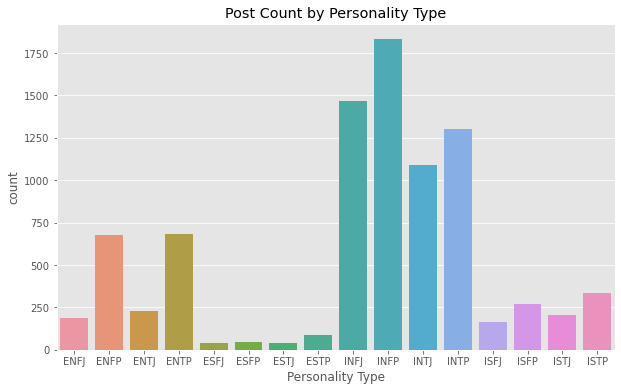

In [10]:
plt.subplots(figsize=(10,6))
sns.countplot(x = mb_df['type'].sort_values())
plt.title('Post Count by Personality Type')
plt.xlabel('Personality Type');

**Post Count by Personality Type:** Above, it is clear that the 4 personality types that we have the most information on are INFJ, INFP, INTJ, and INTP. We will probably have a harder time predicting ESFJ, ESFP, ESTP, and ESTP, since we have very few posts from each of these types. This is a good indicator that we should stratify our train test split data.

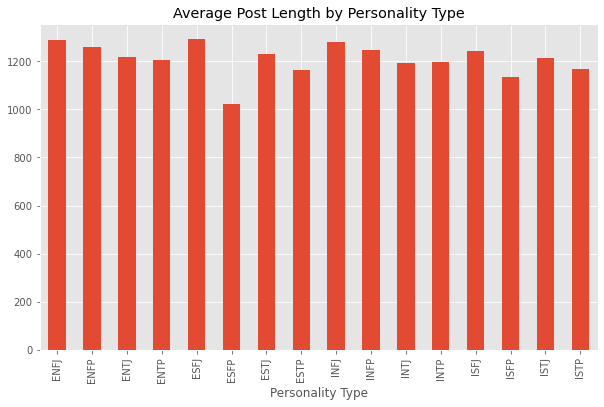

In [11]:
plt.subplots(figsize=(10,6))
mb_df.groupby('type')['post_length'].mean().plot(kind='bar')
plt.title('Average Post Length by Personality Type')
plt.xlabel('Personality Type');

**Average Post Length by Personality Type:** There aren't many distinctions here, besides ESFP which has visibly shorter posts. 

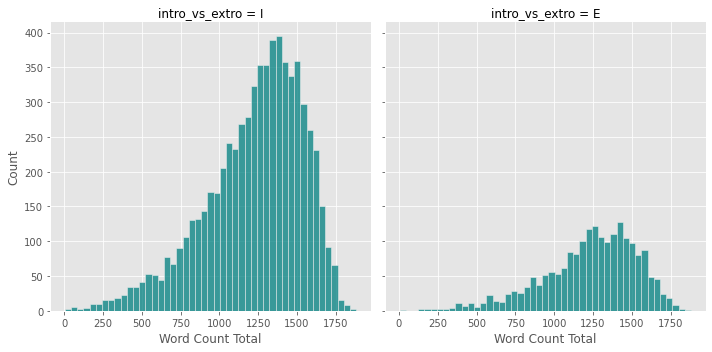

In [12]:
g = sns.displot(data=mb_df, x='post_length', col='intro_vs_extro', color='teal')
g.set_axis_labels('Word Count Total', 'Count');

In [13]:
cvect = CountVectorizer()

In [14]:
posts_vect = cvect.fit_transform(mb_df['posts'])

In [15]:
posts_vect_df = pd.DataFrame(posts_vect.toarray(), columns = cvect.get_feature_names())

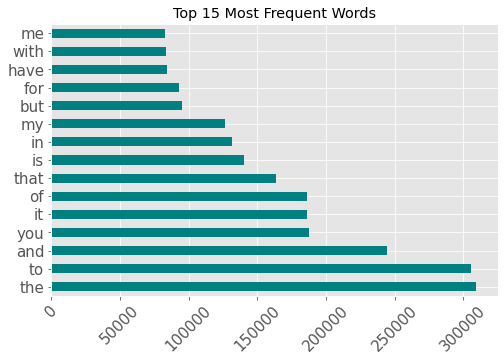

In [16]:
plt.subplots(figsize=(8,5))
posts_vect_df.sum().nlargest(15).plot(kind='barh', color='teal', fontsize=15)
plt.title('Top 15 Most Frequent Words');
plt.xticks(rotation=45);

In [17]:
intro_vect = cvect.fit_transform(mb_df[mb_df['intro_vs_extro']=='I']['posts'])

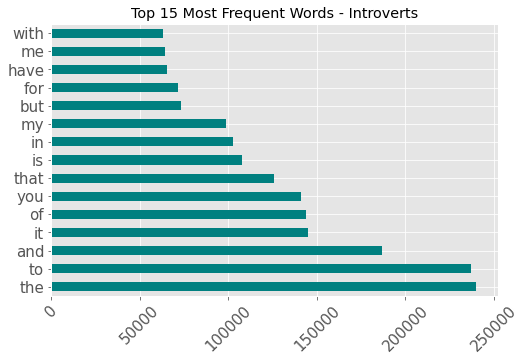

In [18]:
intro_vect_df = pd.DataFrame(intro_vect.toarray(), columns = cvect.get_feature_names())
plt.subplots(figsize=(8,5))
intro_vect_df.sum().nlargest(15).plot(kind='barh', color='teal', fontsize=15)
plt.title('Top 15 Most Frequent Words - Introverts');
plt.xticks(rotation=45);

In [19]:
extro_vect = cvect.fit_transform(mb_df[mb_df['intro_vs_extro']=='E']['posts'])

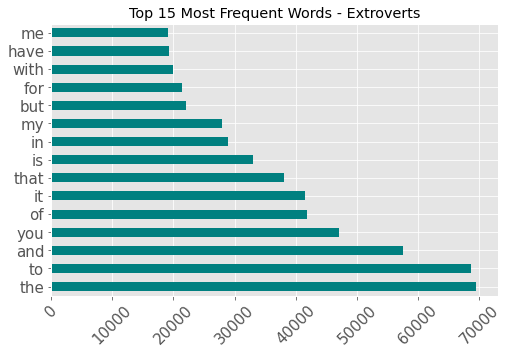

In [20]:
extro_vect_df = pd.DataFrame(extro_vect.toarray(), columns = cvect.get_feature_names())
plt.subplots(figsize=(8,5))
extro_vect_df.sum().nlargest(15).plot(kind='barh', color='teal', fontsize=15)
plt.title('Top 15 Most Frequent Words - Extroverts');
plt.xticks(rotation=45);

In [21]:
cvect2 = CountVectorizer(ngram_range=(2,2), max_features=200)

In [22]:
posts_vect2 = cvect2.fit_transform(mb_df['posts'])

In [23]:
posts_vect2_df = pd.DataFrame(posts_vect2.toarray(), columns = cvect2.get_feature_names())

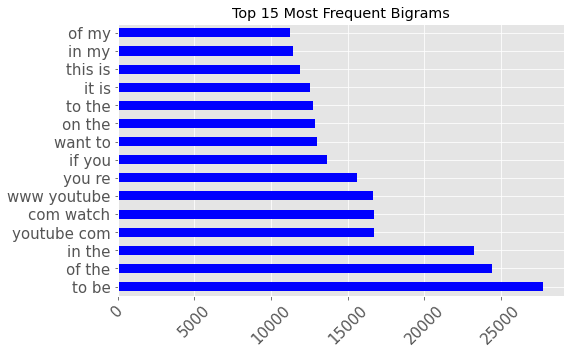

In [24]:
plt.subplots(figsize=(8,5))
posts_vect2_df.sum().nlargest(15).plot(kind='barh', color='blue', fontsize=15)
plt.title('Top 15 Most Frequent Bigrams');
plt.xticks(rotation=45);

### Model the data

In [69]:
mb_df['type_factorized'], names = pd.factorize(mb_df['type'])

In [109]:
mb_df['type'].value_counts(normalize=True)

INFP    0.211182
INFJ    0.169452
INTP    0.150317
INTJ    0.125764
ENTP    0.078963
ENFP    0.077810
ISTP    0.038847
ISFP    0.031239
ENTJ    0.026628
ISTJ    0.023631
ENFJ    0.021902
ISFJ    0.019135
ESTP    0.010259
ESFP    0.005533
ESFJ    0.004841
ESTJ    0.004496
Name: type, dtype: float64

In [70]:
mb_df.head()

,type,posts,post_length,intro_vs_extro,type_factorized
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,556,I,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1170,E,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,836,I,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1064,I,3
4,ENTJ,'You're fired.|||That's another silly misconce...,967,E,4


In [71]:
names

Index(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP',
       'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype='object')

In [72]:
X = mb_df['posts']
y = mb_df['type']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, stratify=y)

In [74]:
pipe = make_pipeline(CountVectorizer(stop_words = 'english'), MultinomialNB())

params = {
    'countvectorizer__max_features': [200, 500, 1000],
#     'countvectorizer__ngram_range': [(1,1), (1,2), (1,3)]
}

grid = GridSearchCV(pipe, params, n_jobs=-1)

In [75]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [200, 500, 1000]})

In [76]:
print('Train score: ', grid.score(X_train, y_train))
print('Test score: ', grid.score(X_test, y_test))

Train score:  0.6163541346449432
Test score:  0.5527893038266483


In [77]:
grid.best_params_

{'countvectorizer__max_features': 500}

In [78]:
preds = grid.predict(X_test)

<AxesSubplot:ylabel='count'>

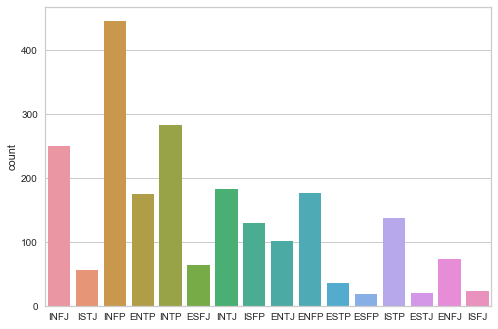

In [79]:
sns.countplot(preds)

In [80]:
cvect = CountVectorizer(stop_words = 'english', max_features=500)

In [81]:
X_train_vect = cvect.fit_transform(X_train)
X_test_vect = cvect.transform(X_test)

In [82]:
y = mb_df['type_factorized']

In [83]:
model = MultinomialNB()

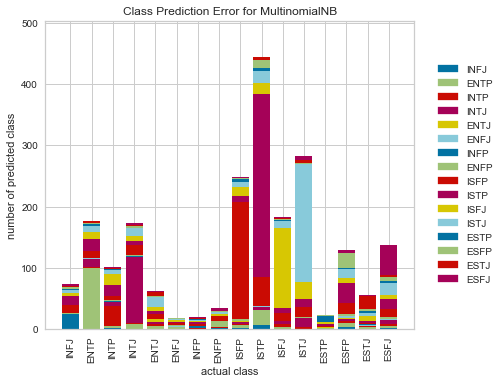

In [84]:
from yellowbrick.classifier import ClassPredictionError
visualizer = ClassPredictionError(
    model, classes=names)
visualizer.fit(X_train_vect, y_train)
visualizer.score(X_test_vect, y_test)
visualizer.show();

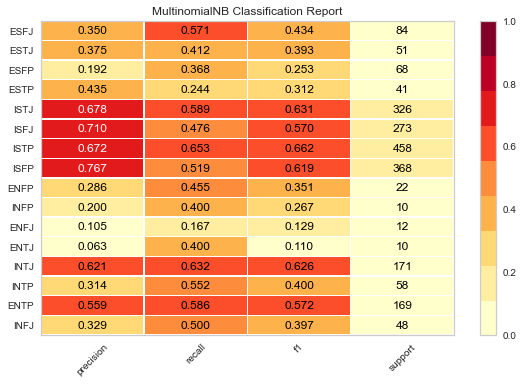

In [92]:
from yellowbrick.classifier import ClassificationReport

vizualizer = ClassificationReport(model, classes=names, support=True)
vizualizer.fit(X_train_vect, y_train)
vizualizer.score(X_test_vect, y_test)
vizualizer.show();

In [93]:
pipe2 = make_pipeline(CountVectorizer(stop_words = 'english', max_features = 500), RandomForestClassifier(max_depth=50))

params2 = {
    'randomforestclassifier__n_estimators': [500, 1000],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
#     'randomforestclassifier__max_depth': [25, 50, 100], 
}

grid2 = GridSearchCV(pipe2, params2, n_jobs=-1)

In [94]:
grid2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=500,
                                                        stop_words='english')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_depth=50))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [500, 1000]})

In [95]:
grid2.best_params_

{'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 500}

In [96]:
grid2.score(X_train, y_train)

1.0

In [108]:
print('Random Forest Train score: ', grid2.score(X_train, y_train))
print('Random Forest Test score: ', grid2.score(X_test, y_test))

Random Forest Train score:  1.0
Random Forest Test score:  0.6173351775011526


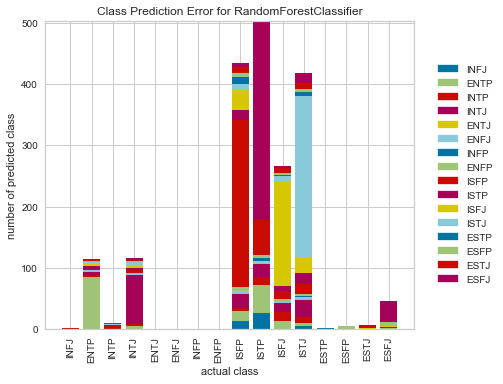

In [98]:
model2 = RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=500)
visualizer = ClassPredictionError(
    model2, classes=names)
visualizer.fit(X_train_vect, y_train)
visualizer.score(X_test_vect, y_test)
visualizer.show();

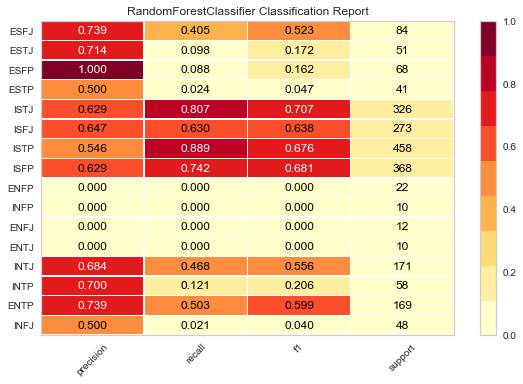

In [99]:
vizualizer = ClassificationReport(model2, classes=names, support=True)
vizualizer.fit(X_train_vect, y_train)
vizualizer.score(X_test_vect, y_test)
vizualizer.show();

In [101]:
pipe3 = make_pipeline(CountVectorizer(stop_words = 'english', max_features = 500), GradientBoostingClassifier())

params3 = {
    'gradientboostingclassifier__n_estimators': [100, 200, 500],
}

grid3 = GridSearchCV(pipe3, params3, n_jobs=-1)

In [102]:
grid3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=500,
                                                        stop_words='english')),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__n_estimators': [100, 200,
                                                                      500]})

In [103]:
print('Boosted Train score: ', grid3.score(X_train, y_train))
print('Boosted Test score: ', grid3.score(X_test, y_test))

Boosted Train score:  0.9973870273593606
Boosted Test score:  0.6560627017058552


In [104]:
grid3.best_params_

{'gradientboostingclassifier__n_estimators': 500}

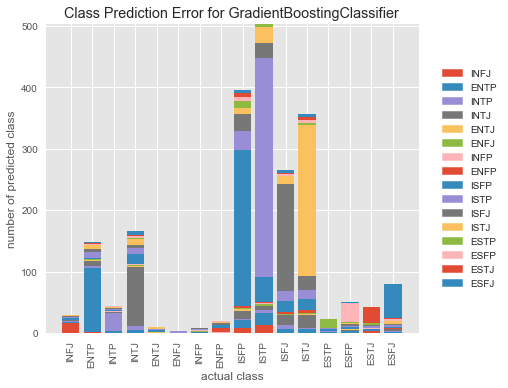

In [106]:
model3 = GradientBoostingClassifier(n_estimators=500)
visualizer = ClassPredictionError(
    model3, classes=names)
visualizer.fit(X_train_vect, y_train)
visualizer.score(X_test_vect, y_test)
visualizer.show();

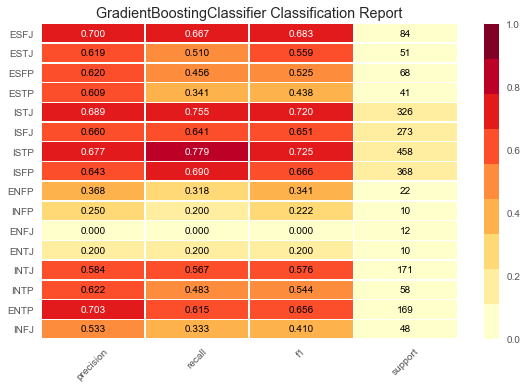

In [107]:
vizualizer = ClassificationReport(model3, classes=names, support=True)
vizualizer.fit(X_train_vect, y_train)
vizualizer.score(X_test_vect, y_test)
vizualizer.show();